# TensorFlow CNN - Malaria Predictions

Note - the model here is presented as an example only; it was not finalised due to computational requirements.

The model was training on a subset of 1,000 positive and 1,000 negative-class images, out of the full set of 13,780 for each class.

In [ ]:
from pathlib import Path
from collections import Counter
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.subplots as sp
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Conv2D, MaxPooling2D
from tqdm.notebook import tqdm

## Load data

In [ ]:
# Paths to image folders
positive_image_path = Path("cell_images/Parasitized")
negative_image_path = Path("cell_images/Uninfected")

In [ ]:
# Initialise lists for images and class labels
images, labels = [], []

In [ ]:
counter = 0
# Iterate through first 1,000 positive class images
for png in tqdm(positive_image_path.glob("*.png"), desc="Loading 1,000 positive class images"):
    counter += 1
    if counter > 1000:
        break

    # Load image
    img = image.load_img(png)
    # Resize image
    resized_image = tf.image.resize(img, size=(128, 128), preserve_aspect_ratio=False)
    # Convert image to numpy array
    image_array = image.img_to_array(resized_image)
    # Add image array to list of images
    images.append(image_array)
    # Add positive label to labels list
    labels.append(1)


Loading 1,000 positive class images: 0it [00:00, ?it/s]

In [ ]:
counter = 0
# Iterate through first 1,000 negative class images
for png in tqdm(negative_image_path.glob("*.png"), desc="Loading 1,000 negative class images"):
    counter += 1
    if counter > 1000:
        break

    # Load image
    img = image.load_img(png)
    # Resize image
    resized_image = tf.image.resize(img, size=(128, 128), preserve_aspect_ratio=False)
    # Convert image to numpy array
    image_array = image.img_to_array(resized_image)
    # Add image array to list of images
    images.append(image_array)
    # Add negative label to labels list
    labels.append(0)


Loading 1,000 negative class images: 0it [00:00, ?it/s]

In [ ]:
X = np.asarray(images)

In [ ]:
X.shape

(2000, 128, 128, 3)

In [ ]:
X[0].shape

(128, 128, 3)

In [ ]:
y = np.asarray(labels)

In [ ]:
y.shape

(2000,)

In [ ]:
# Get no. unique values
unique_values, counts = np.unique(y, return_counts=True)
for value, count in zip(unique_values, counts):
    print(f"{value}, {count}")

0, 1000
1, 1000


## Split train and test data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=27)

In [ ]:
# Get no. unique values
unique_values, counts = np.unique(y_train, return_counts=True)
for value, count in zip(unique_values, counts):
    print(f"{value}, {count}")

0, 820
1, 780


In [ ]:
X_train.shape

(1600, 128, 128, 3)

In [ ]:
X_test.shape

(400, 128, 128, 3)

In [ ]:
# Image dimensions
img_rows, img_cols = 128, 128

In [ ]:
input_shape = (img_rows, img_cols, 3)

## Transform data

In [ ]:
# Convert data types for train and test data
X_train = X_train.astype("float32")
X_test = X_test.astype("float32")

In [ ]:
# Scale train and test data
X_train /= 255.
X_test /= 255.

In [ ]:
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape:  {X_test.shape}")

X_train shape: (1600, 128, 128, 3)
X_test shape:  (400, 128, 128, 3)


In [ ]:
print(y_train[:10])

[1 1 1 0 0 1 1 0 1 1]


## VGG Model

I will test a VGG-style model for this classification task.

### Prepare the model architecture

In [ ]:
input_shape

(128, 128, 3)

In [ ]:
# Create CNN to classify images
def create_VGG():
    """
    Initialises a convolutional neural network
    with VGG-style architecture
    """
    # Initialise the model
    model = Sequential()
    # Input layer and first convolution block
    model.add(Conv2D(64, kernel_size=(3, 3), activation="relu", kernel_initializer="he_uniform", padding="same", input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Conv2D(64, kernel_size=(3, 3), activation="relu", kernel_initializer="he_uniform", padding="same"))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    # Second convolution block
    model.add(Conv2D(128, kernel_size=(3, 3), activation="relu", kernel_initializer="he_uniform", padding="same"))
    model.add(BatchNormalization())
    model.add(Conv2D(128, kernel_size=(3, 3), activation="relu", kernel_initializer="he_uniform", padding="same"))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    # Third convolution block
    model.add(Conv2D(256, kernel_size=(3, 3), activation="relu", kernel_initializer="he_uniform", padding="same"))
    model.add(BatchNormalization())
    model.add(Conv2D(256, kernel_size=(3, 3), activation="relu", kernel_initializer="he_uniform", padding="same"))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    # Classification block
    model.add(Flatten())
    model.add(Dense(256, activation="relu", kernel_initializer="he_uniform"))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Dense(256, activation="relu", kernel_initializer="he_uniform"))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Dense(64, activation="relu", kernel_initializer="he_uniform"))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Dense(1, activation="sigmoid"))
    # Compile model
    model.compile(loss=keras.losses.binary_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=["accuracy"])

    return model



In [ ]:
def summarise_diagnostics(history):
    """
    Plots performance metrics
    """
    # Plot loss
    plt.subplot(211)
    plt.title("Cross Entropy Loss")
    plt.plot(history.history["loss"], color="green", label="train")
    plt.plot(history.history["val_loss"], color="red", label="test")
    # Plot accuracy
    plt.subplot(212)
    plt.title("Classification Accuracy")
    plt.plot(history.history["accuracy"], color="green", label="train")
    plt.plot(history.history["val_accuracy"], color="red", label="test")



### Note: keeping the batch_size and no. epochs low, for demo only

In [ ]:
# Set batch size and no. epochs
batch_size = 64
epochs = 10

In [ ]:
# Define model
model_VGG = create_VGG()
# Fit model
history = model_VGG.fit(
    X_train,
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_test, y_test),
    verbose=1
)

In [ ]:
# Evaluate model with test data
score = model_VGG.evaluate(X_test, y_test, verbose=1)
print(f"Test loss:      {score[0]:.2%}")
print(f"Test accuracy:  {score[1]:.2%}")

13/13 [==============================] - 13s 967ms/step - loss: 0.9932 - accuracy: 0.7550
Test loss:      99.32%
Test accuracy:  75.50%


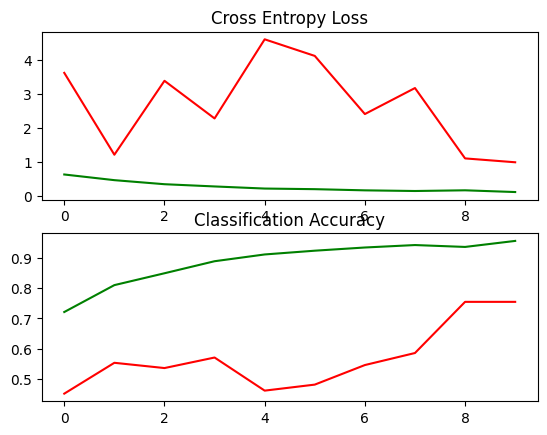

In [ ]:
# Plot metrics
summarise_diagnostics(history)

In [ ]:
model_VGG.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      1792      
                                                                 
 batch_normalization (Batch  (None, 128, 128, 64)      256       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      36928     
                                                                 
 batch_normalization_1 (Bat  (None, 128, 128, 64)      256       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 64)        0         
 D)                                                              
                                                        